In [11]:
using PyPlot; plt=PyPlot
using PyCall
using FastGaussQuadrature, Compat
using LinearAlgebra
using LaTeXStrings
using DifferentialEquations

In [12]:
include("ADER.jl")
include("DeC.jl")

nodesm[0.0, 0.0, 0.0]weightsm[0.0, 0.0, 0.0]nodesm[0.0, 0.25, 0.5]weightsm[0.08333333333333333, 0.3333333333333333, 0.08333333333333333]nodesm[0.0, 0.5, 1.0]weightsm[0.16666666666666666, 0.6666666666666666, 0.16666666666666666]

3×3 Array{Float64,2}:
 0.0   0.208333   0.166667
 0.0   0.333333   0.666667
 0.0  -0.0416667  0.166667

In [12]:
# Scalar case:

#linear
function linear_scalar_flux(u,k_coef=10)
    ff=zeros(size(u))
    ff[1]=-k_coef*u[1]
    return ff
end

function linear_scalar_exact_solution(u0,t,k_coef=10)
    return [exp(-k_coef*u0[1]*t)]
end


#nonlinear
function scalar_flux(u,k_coef=10)
    ff=zeros(size(u))
    ff[1]=-k_coef*abs(u[1])*u[1] +1
    return ff
end

function scalar_exact_solution(u0,t)
        k_coef = 10
        sqrtk = sqrt(k_coef)
        ustar = 1 / sqrtk

        if u0[1] >= ustar
            [coth(sqrtk * t + acoth(sqrtk * u0[1])) / sqrtk]
        elseif u0[1] < 0 && t < - atan(sqrtk * u0[1]) / sqrtk
            [tan(sqrtk * t + atan(sqrtk * u0)) / sqrtk]
        else
            [tanh(sqrtk * t + atanh(sqrtk * u0[1])) / sqrtk]
        end
end

# Lotka:
function lotka_flux(u,alpha=1,beta=0.2,delta=0.5,gamma=0.2)
    ff=zeros(size(u))
    ff[1]=alpha*u[1]-beta*u[1]*u[2]
    ff[2]=delta*beta*u[1]*u[2]-gamma*u[2]
    return ff
 end

function lotka!(du,u,p,t)
    alpha=1
    beta=0.2
    delta=0.5
    gamma=0.2
    du[1]=alpha*u[1]-beta*u[1]*u[2]
    du[2]=delta*beta*u[1]*u[2]-gamma*u[2]
end

function lotka_exact_solution(u0,t)
    # this has to be fixed for speed...
    tspan = (0.0,t)
    prob = ODEProblem(lotka!,u0,tspan)
    sol = solve(prob,reltol=1e-16, abstol=1e-16)
    a = sol.u[end,:]
    return(a[:][1])
end
    

# nonlinear oscilator
function nonlinear_oscilator_flux(u)
    d=zeros(length(u))
	d[1]= -u[2]/(u[1]^2 + u[2]^2)
	d[2]= u[1]/(u[1]^2 + u[2]^2)
    return d
end

function nonlinear_oscilator_flux!(du,u,p,t)
    d=zeros(length(u))
	du[1]= -u[2]/(u[1]^2 + u[2]^2)
	du[2]= u[1]/(u[1]^2 + u[2]^2)
end

function nonlinear_oscilator_exact_solution(u0,t)
    # this has to be fixed for speed...
    tspan = (0.0,t)
    prob = ODEProblem(nonlinear_oscilator_flux!,u0,tspan)
    sol = solve(prob,reltol=1e-16, abstol=1e-16)
    a = sol.u[end,:]
    return(a[:][1])
end


# linear system
function linear_system_flux(u)
    d=zeros(length(u))
	d[1]= -u[1] + 3*u[2]
    d[2]= -3*u[2] + 5*u[3]
    d[3]= -5*u[3]
    return d
end

function linear_system_exact_solution(u0,t)
    # this has to be fixed for speed...
    u_e = zeros(length(u0))
    u_e[1] = 15.0/8.0*u0[3]*(exp(-5*t) - 2*exp(-3*t)+exp(-t))
    u_e[2] = 5.0/2.0*u0[3]*(-exp(-5*t) + exp(-3*t))
    u_e[3] = u0[3]*exp(-5*t)
    return u_e
end


#Other fcts:
function compute_integral_error(c,c_exact)  # c is dim x times
  times=size(c)[2]
  error=0.
  for t = 1: times
    error = error + norm(c[:,t]-c_exact[:,t],2)^2.
  end
  
  error = sqrt(error/times) 
  return error

end

compute_integral_error (generic function with 1 method)

In [15]:
problem = "scalar"

function setup(problem)
    
    if problem == "scalar"
        k_coef = 1
        u0 = [1.1/sqrt(k_coef)]
        T_fin=0.15
        flux = scalar_flux
        exact_solution = scalar_exact_solution
    elseif problem=="lotka"
        u0=[1.0,2.0]
        T_fin=200.0
        flux = lotka_flux
        exact_solution = lotka_exact_solution
    elseif problem =="linear-scalar"
        u0 = [1.0]
        T_fin=0.15
        flux = linear_scalar_flux
        exact_solution = linear_scalar_exact_solution
    elseif problem == "nonlinear-oscilator"
        u0 = [1.0,0.0]
        T_fin = 10.0
        flux = nonlinear_oscilator_flux
        exact_solution = nonlinear_oscilator_exact_solution
        elseif problem == "linear-system"
        u0 = [0.0,0.0,10.0]
        T_fin = 10.0
        flux = linear_system_flux
        exact_solution = linear_system_exact_solution
    end
    
    return u0, T_fin, flux, exact_solution
end

setup (generic function with 1 method)

In [16]:
function plot_save_convergence(flux,exact_solution,xmin,xmax,ymin,ymax,T_fin=0.01,name="default.pdf")
    plt.figure(figsize=(5,8))
    nn_end = 12
    nn_start = 3
    Nn = nn_end - nn_start + 1
    ns= 2 .^(nn_start:nn_end)
    maxOrder = 10
    error_DeCeq=zeros(Nn,maxOrder)
    error_DeCGL=zeros(Nn,maxOrder)
    error_ADEReq=zeros(Nn,maxOrder)
    error_ADERGLB=zeros(Nn,maxOrder)
    error_ADERGLG=zeros(Nn,maxOrder)
    for it=1:Nn
        n=ns[it]
        tt=range(0,stop=T_fin,length=n+1)
        u_exact=zeros(size(u0)[1],size(tt)[1])
        for k=1:size(tt)[1]
            u_exact[:,k]=exact_solution(u0,tt[k])
        end
        for k=1:maxOrder
            tout,uu=ADER_ODE(flux, tt, u0, k, k+1, "equispaced")
            error_ADEReq[it,k]=compute_integral_error(uu,u_exact)
            tout,uu=ADER_ODE(flux, tt, u0, k, k+1, "gaussLobatto")
            error_ADERGLB[it,k]=compute_integral_error(uu,u_exact)
            tout,uu=ADER_ODE(flux, tt, u0, k, k+1, "gaussLegendre")
            error_ADERGLG[it,k]=compute_integral_error(uu,u_exact)
            tout,uu=dec_Remi(flux, tt, u0, k, k+1, "equispaced")
            error_DeCeq[it,k]=compute_integral_error(uu,u_exact)
            tout,uu=dec_Remi(flux, tt, u0, k, k+1, "gaussLobatto")
            error_DeCGL[it,k]=compute_integral_error(uu,u_exact)
        end
    end

    plt.cla()
    plt.clf()
    for k=1:10
        plt.loglog(T_fin./ns,error_ADERGLG[:,k], label="ADER$(k+1) GL",linestyle="--",color="blue",linewidth=1)
        plt.loglog(T_fin./ns,error_ADERGLB[:,k], label="ADER$(k+1) GLB",linestyle="-",color="blue",linewidth=1)
        plt.loglog(T_fin./ns,error_ADEReq[:,k], "-", label="ADER$(k+1) equi",linestyle=":",color="blue",linewidth=1)
        plt.loglog(T_fin./ns,error_DeCGL[:,k], "-", label="DEC$(k+1) GLB",linestyle="-",color="green",linewidth=1)
        plt.loglog(T_fin./ns,error_DeCeq[:,k], "-", label="DEC$(k+1) equi",linestyle=":",color="green",linewidth=1)
        plt.loglog(T_fin./ns, error_ADEReq[1,k]*ns[1].^((k+1))*1 ./ns.^(k+1),":",color="grey")

        plt.text(T_fin./ns[1] + 0.005, error_ADEReq[1,k], "m = $(k+1)",fontsize=8,color="grey")
        plt.xlabel(L"\Delta t")
        plt.ylabel("Error")

    end

    plt.legend(["ADER GL","ADER GLB","ADER EQ","DEC GLB","DEC EQ"],loc="best",bbox_to_anchor=(1.05, 1.01))
    
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    plt.show()
    plt.savefig(name, bbox_inches="tight")

end

plot_save_convergence (generic function with 3 methods)

# Linear Scalar

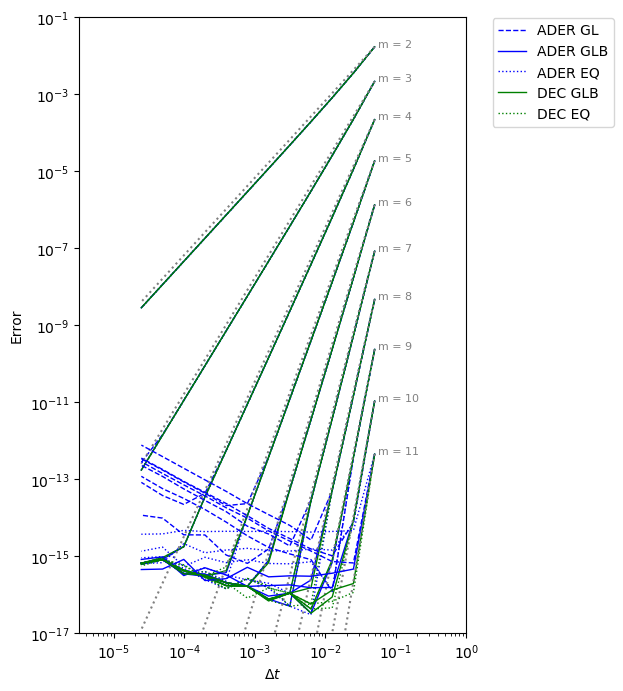

In [98]:
u0, T_fin , flux , exact_solution = setup("linear-scalar")

plot_save_convergence(flux,exact_solution,10^-5.5,10^0,10^-17,10^-1,0.1,"linear-scalar_2")

# Nonlinear scalar case

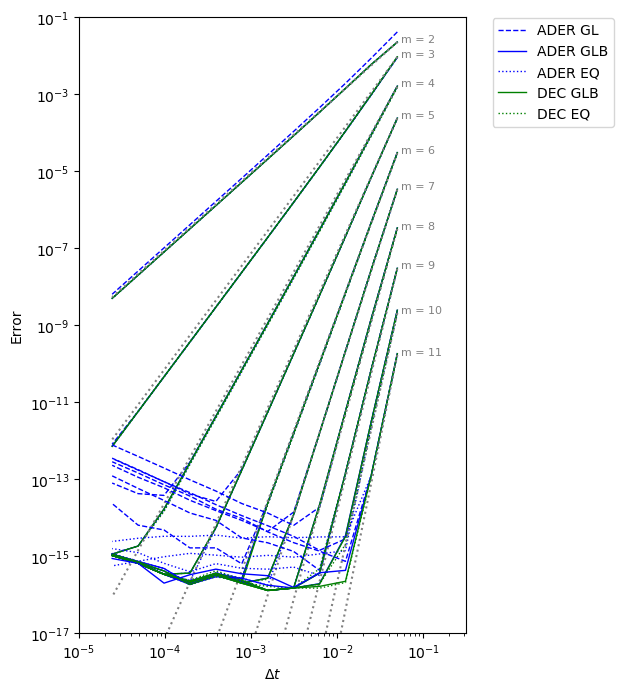

In [99]:
u0, T_fin , flux , exact_solution = setup("scalar")
plot_save_convergence(flux,exact_solution,10^-5,10^-0.5,10^-17,10^-1,0.1,"scalar-2")

# Lotka Voltera case

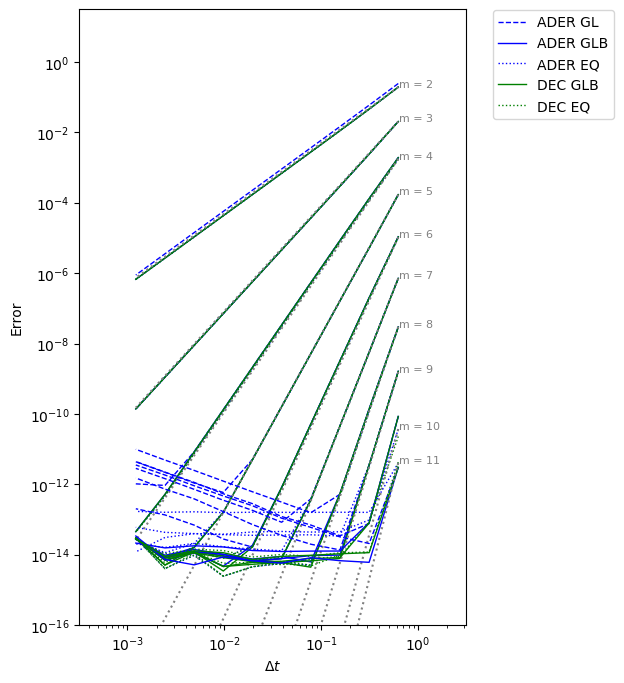

In [225]:
u0, T_fin , flux , exact_solution = setup("lotka")
plot_save_convergence(flux,exact_solution,10^-3.5,10^0.5,10^-16,10^1.5,5.0,"lotka-2")

# Nonlinear oscilator

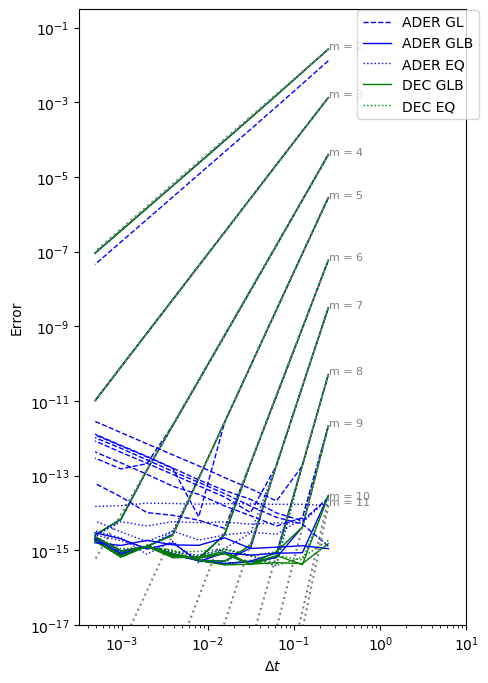

In [222]:
u0, T_fin , flux , exact_solution = setup("nonlinear-oscilator")
plot_save_convergence(flux,exact_solution,10^-3.5,10^1,10^-17,10^-0.5,2.0,"nonlinear-oscilator")


# Linear system

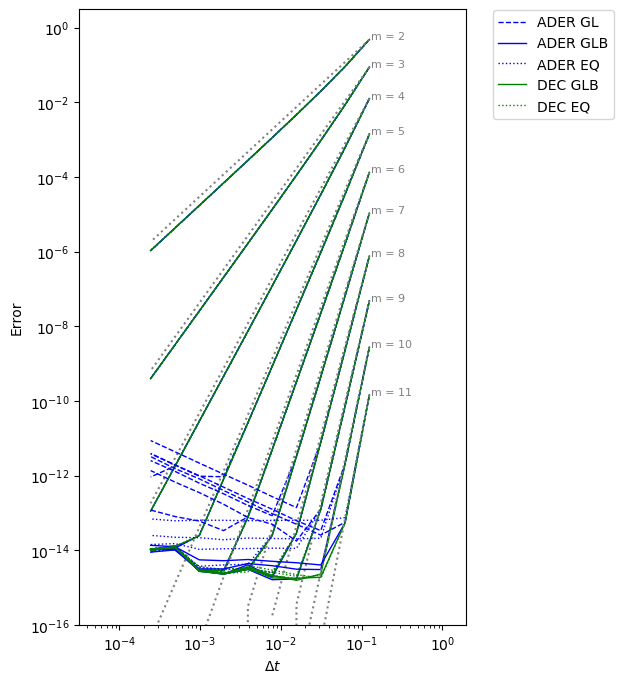

In [229]:
u0, T_fin , flux , exact_solution = setup("linear-system")
plot_save_convergence(flux,exact_solution,10^-4.5,10^0.3,10^-16,10^0.5,1.0,"linear-system")


# Long term behaviour

In [17]:
u0, T_fin , flux , exact_solution = setup("lotka")
anal_l = 2000
t_ex = range(0,stop=100.0,length=anal_l)
u_ex = zeros(length(u0),length(t_ex))
for k = 1:anal_l
    u_ex[:,k] = exact_solution(u0,t_ex[k])
end

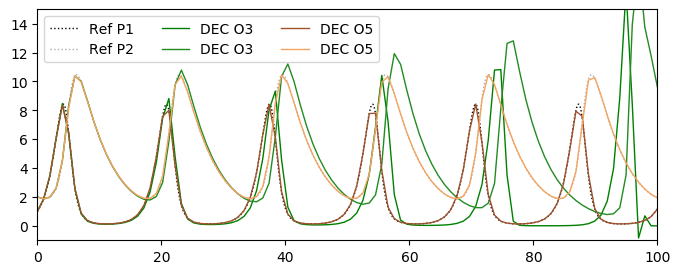

"\nplt.plot(t2,U2[1,:],linewidth=1,color=\"red\",label=\"ADER O3\")\nplt.plot(t2,U2[2,:],linewidth=1,color=\"darkred\",label=\"ADER O3\")\nplt.plot(t2,U3[1,:],linewidth=1,color=\"blue\",label=\"ADER O5\")\nplt.plot(t2,U3[2,:],linewidth=1,color=\"darkblue\",label=\"ADER O5\")\n"

In [88]:
N = 100
plt.figure(figsize=(8,3))
tt = range(0,stop=100.0,length=N)
t2,U2=dec_Remi(flux, tt, u0, 2,3, "gaussLobatto")
t2,U3=dec_Remi(flux, tt, u0, 4,5,"gaussLobatto")

plt.plot(t_ex, u_ex[1,:],linestyle=":",linewidth=1,color="black",label="Ref P1")
plt.plot(t_ex, u_ex[2,:],linestyle=":",linewidth=1,color="darkgray",label="Ref P2")


plt.plot(t2,U2[1,:],linewidth=1,color="green",label="DEC O3")
plt.plot(t2,U2[2,:],linewidth=1,color="forestgreen",label="DEC O3")
plt.plot(t2,U3[1,:],linewidth=1,color="sienna",label="DEC O5")
plt.plot(t2,U3[2,:],linewidth=1,color="sandybrown",label="DEC O5")

plt.legend(loc="top left",ncol=3)
plt.xlim([0,100])
plt.ylim([-1,15])
plt.savefig("n100_dec", bbox_inches="tight")
